# **Model Selection to estimate Agents**

For each station, find a good model to predict the individual pollutants.

## **Input Data**

Using the process defined in the [training data notebook](./4-training-and-test-sets.ipynb), initiate the datasets.

In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_squared_error

from sklearn.model_selection import train_test_split

from utils import *

datasets_folder = './datasets'
figsize = (20,4)
verbosity = 0

metrics = [root_mean_squared_error, r2_score, mean_absolute_error, mean_squared_error]

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [3]:
station_data = {}
station_dists = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station], station_dists[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 33


In [4]:
display(station_dists)

{'GIARDINI MARGHERITA': {'NO2': {'mean': 17.14072246079708,
   'std': 12.589960677710152},
  'O3': {'mean': 48.98513118969818, 'std': 37.85270921807842},
  'PM10': {'mean': 22.20440402106271, 'std': 14.35686586458016},
  'PM2.5': {'mean': 14.051379638439581, 'std': 11.600695276128905}},
 'PORTA SAN FELICE': {'C6H6': {'mean': 0.9688234692834509,
   'std': 0.7330867585635198},
  'CO': {'mean': 0.5785835715941582, 'std': 0.3103118559994582},
  'NO2': {'mean': 39.715971049925294, 'std': 19.291830402469508},
  'PM10': {'mean': 25.287928604978863, 'std': 15.314443827291322},
  'PM2.5': {'mean': 15.613508442776736, 'std': 11.841427071912088}},
 'VIA CHIARINI': {'NO2': {'mean': 17.894294457140642,
   'std': 13.343017704259504},
  'O3': {'mean': 44.30093526855014, 'std': 38.50975182521014},
  'PM10': {'mean': 22.216216216216218, 'std': 13.584743601968238}}}

We can inspect the hourly and daily features:

In [5]:
station_data['GIARDINI MARGHERITA']['NO2'].columns

Index(['Agent_value', 'Traffic_value', 'TAVG', 'PREC', 'RHAVG', 'RAD',
       'W_SCAL_INT', 'W_VEC_DIR', 'LEAFW', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'month_rbf_1', 'month_rbf_2', 'month_rbf_3', 'month_rbf_4',
       'month_rbf_5', 'month_rbf_6', 'month_rbf_7', 'month_rbf_8',
       'month_rbf_9', 'month_rbf_10', 'month_rbf_11', 'month_rbf_12'],
      dtype='object')

In [6]:
station_data['GIARDINI MARGHERITA']['PM2.5'].columns

Index(['Agent_value', 'Traffic_0-2', 'Traffic_3-5', 'Traffic_6-8',
       'Traffic_9-11', 'Traffic_12-14', 'Traffic_15-17', 'Traffic_18-20',
       'Traffic_21-0', 'TAVG', 'PREC', 'RHAVG', 'RAD', 'W_SCAL_INT',
       'W_VEC_DIR', 'LEAFW', 'TAVG_MAX', 'TAVG_MIN', 'RHAVG_MAX', 'RHAVG_MIN',
       'day_sin', 'day_cos', 'month_rbf_1', 'month_rbf_2', 'month_rbf_3',
       'month_rbf_4', 'month_rbf_5', 'month_rbf_6', 'month_rbf_7',
       'month_rbf_8', 'month_rbf_9', 'month_rbf_10', 'month_rbf_11',
       'month_rbf_12'],
      dtype='object')

As we can see for daily data we have the correct encoding of the hourly values for the traffic and the weather (like 'TAVG_MAX','TAVG_MIN', 'RHAVG_MAX', 'RHAVG_MIN') and the data encoding.

## **Training Data**

Our data covers 2019, ..., 2024. We decided to use 2024 as the test set.

In [7]:
train_split_date = datetime(2023,12,31,23)
RANDOM_STATE = 42

In [8]:
train_sets = {}
test_sets = {}

for station in stations:
    train_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        train_sets[station][agent] = {}
        test_sets[station][agent] = {}

        X_train, y_train, X_test, y_test = create_train_test(station_data[station][agent], train_split_date, y='Agent_value')

        train_sets[station][agent]['x'] = X_train
        train_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = X_test
        test_sets[station][agent]['y'] = y_test

In [9]:
train_sets['GIARDINI MARGHERITA']['NO2']['x'].head(1) # example

,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,-0.548779,-1.741683,-0.13755,1.320229,-0.663642,-1.41615,0.046922,-0.464033,0.0,1.0,...,0.000335,1.522998e-08,1.266417e-14,1.928750e-22,5.380186e-32,1.928750e-22,1.266417e-14,1.522998e-08,0.000335,0.135335


In [10]:
train_sets['GIARDINI MARGHERITA']['NO2']['y'].head(1)

,Agent_value
Date,
2019-01-01,0.941972


## **Models**

- We define different model architectures to try evaluate the pollutants.
- A good result would be a certain architecture resulting in the best results for certain agents across all the stations, or even across all the agents.
- Certain models will use sequences as input, for example LSTMs and Convolutional Networks. Sequences are created by slicing the input timesteps using a sliding window. We need to fill missing timesteps before creating the sequences, because we have missing data between consecutive measurements. We first resample the input data, masking the values if the models use a masking layer, otherwise we backwards-fill them.

The clear problem of this approach is the fact that it is really hard to find, while testing, a model able to work well with all the agents after being tested on a small subset of them. We will be able to check if the model actually work nice on other agents, but it will most likely work very well just with the agents it has been tested on.

The following models have been tested and produced good results. We will now test all of them across all the stations and agents.

### **Hourly Models**

In [11]:
hour_models = {} # contains tuples: (ModelGenerator, model_params:dict, training_params:dict|None, uses_sequences:bool)

#### Random Forest Regressor

##### *Models*

In [12]:
rfr_params = {
    'n_estimators':300,
    'max_depth':20,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

hour_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

In [13]:
rfr2_params = {
    'n_estimators':500,
    'max_depth':15,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

hour_models['Random Forest Regressor 2'] = (RandomForestRegressor, rfr2_params, None, False)

##### *Testing*

In [14]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_rfr = 'Random Forest Regressor'

In [15]:
rfr_model = RandomForestRegressor(**hour_models[selected_rfr][1])
rfr_model.fit(train_sets[station][agent]['x'], train_sets[station][agent]['y'].to_numpy().ravel())
rfr_pred = rfr_model.predict(test_sets[station][agent]['x'])
rfr_pred_df = pd.DataFrame(rfr_pred, index=test_sets[station][agent]['y'].index)

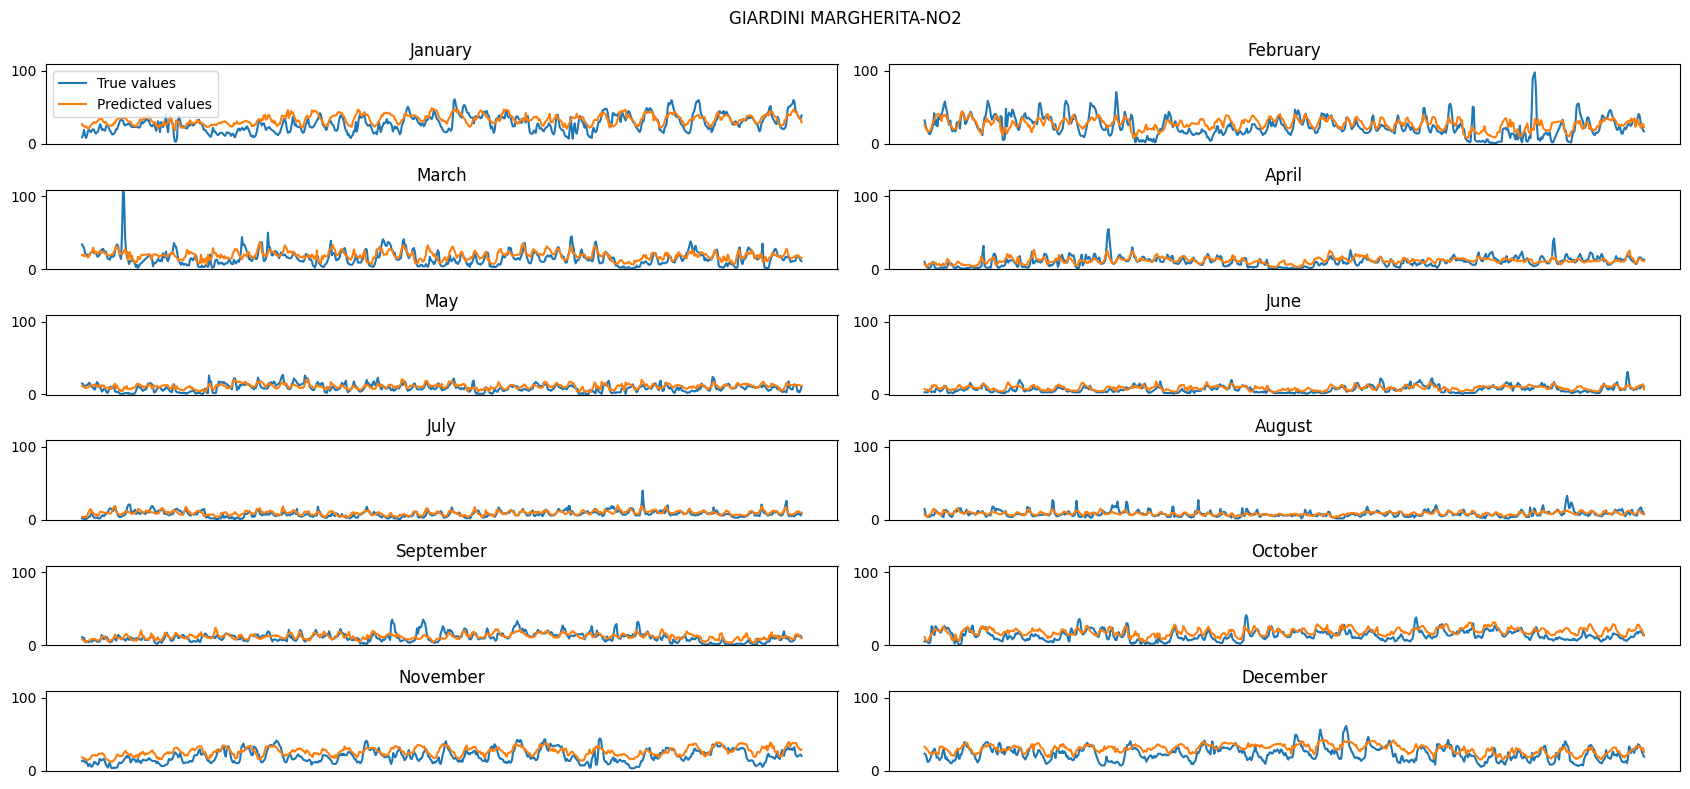

root_mean_squared_error: 0.5913570373146029
r2_score: 0.5038937699373909
mean_absolute_error: 0.4389792039454485
mean_squared_error: 0.34970314558150456


In [16]:
plot_months_predictions(test_sets[station][agent]['y'], rfr_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

#### XGBoost

##### *Models*

In [17]:
xgbr_params = {
    'objective': "reg:absoluteerror",
    'n_estimators': 180,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9,
    'random_state': RANDOM_STATE
}

hour_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

In [18]:
xgbr2_params = {
    'objective': "reg:squarederror",
    'n_estimators': 250,
    'max_depth': 10,
    'learning_rate': 0.1,
    'subsample': 0.75,
    'random_state': RANDOM_STATE
}

hour_models['XGB Regressor 2'] = (xgb.XGBRegressor, xgbr2_params, None, False)

##### *Testing*

In [19]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_xgbr = 'XGB Regressor'

In [20]:
validation_ratio = 0.1

X_train, y_train = train_sets[station][agent]['x'], train_sets[station][agent]['y']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42, shuffle=True)
validation_data = [(X_val, y_val)]

xgbr_model = xgb.XGBRegressor(**hour_models[selected_xgbr][1])
xgbr_model.fit(X_train, y_train, eval_set=validation_data)
xgbr_pred = xgbr_model.predict(test_sets[station][agent]['x'])
xgbr_pred_df = pd.DataFrame(xgbr_pred, index=test_sets[station][agent]['y'].index)

[0]	validation_0-mae:0.76556
[1]	validation_0-mae:0.73245
[2]	validation_0-mae:0.70327
[3]	validation_0-mae:0.67593
[4]	validation_0-mae:0.65123
[5]	validation_0-mae:0.62867
[6]	validation_0-mae:0.60871
[7]	validation_0-mae:0.59058
[8]	validation_0-mae:0.57398
[9]	validation_0-mae:0.55882
[10]	validation_0-mae:0.54477
[11]	validation_0-mae:0.53254
[12]	validation_0-mae:0.52131
[13]	validation_0-mae:0.51084
[14]	validation_0-mae:0.50133
[15]	validation_0-mae:0.49302
[16]	validation_0-mae:0.48498
[17]	validation_0-mae:0.47796
[18]	validation_0-mae:0.47186
[19]	validation_0-mae:0.46623
[20]	validation_0-mae:0.46053
[21]	validation_0-mae:0.45576
[22]	validation_0-mae:0.45152
[23]	validation_0-mae:0.44763
[24]	validation_0-mae:0.44406
[25]	validation_0-mae:0.44063
[26]	validation_0-mae:0.43758
[27]	validation_0-mae:0.43478
[28]	validation_0-mae:0.43196
[29]	validation_0-mae:0.42958
[30]	validation_0-mae:0.42773
[31]	validation_0-mae:0.42585
[32]	validation_0-mae:0.42387
[33]	validation_0-ma

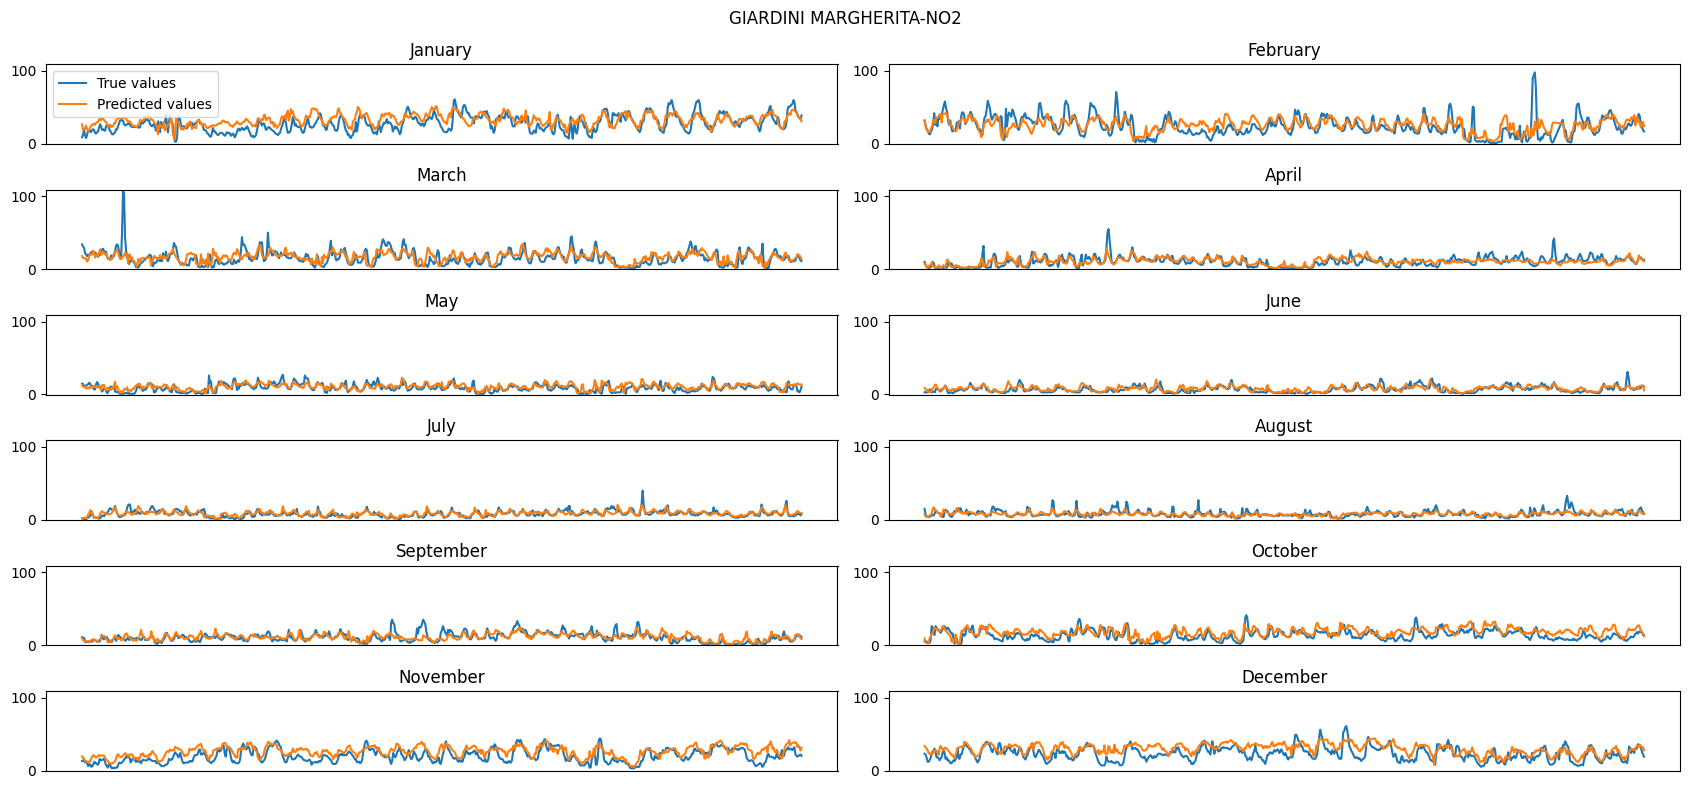

root_mean_squared_error: 0.5782097699904893
r2_score: 0.5257077880810882
mean_absolute_error: 0.4095142045927631
mean_squared_error: 0.33432653811245455


In [21]:
plot_months_predictions(test_sets[station][agent]['y'], xgbr_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

#### LSTM

##### *Models*

In [22]:
lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error',
    'use_mask': False # fill nan using bfill()
}

lstm_train_params = {
    'epochs':20,
    'batch_size':64,
}

hour_models['LSTM'] = (build_lstm_model, lstm_params, lstm_train_params, True)

In [30]:
masked_lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=8e-3),
    'loss': 'mean_absolute_error',
    'use_mask': True # apply a mask to nan, instead of filling
}

masked_lstm_train_params = {
    'epochs':30,
    'batch_size':64,
}

hour_models['LSTM-masked'] = (build_lstm_model, masked_lstm_params, masked_lstm_train_params, True)

In [24]:
lstm2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'lstm_units': [64, 32],
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error',
    'use_mask': False
}

lstm2_train_params = {
    'epochs':20,
    'batch_size':32,
}

hour_models['LSTM 2'] = (build_lstm_model, lstm2_params, lstm2_train_params, True)


In [25]:
masked_lstm2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'lstm_units': [64, 32],
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error',
    'use_mask': True
}

masked_lstm2_train_params = {
    'epochs':20,
    'batch_size':32,
}

hour_models['LSTM 2-masked'] = (build_lstm_model, masked_lstm2_params, masked_lstm2_train_params, True)


##### *Testing*

In [31]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_lstm = 'LSTM-masked'

In [32]:
validation_ratio = 0.1
selected_lstm_model = hour_models[selected_lstm]

ts = selected_lstm_model[1]['time_steps']
lstm_X_train, lstm_y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)

lstm_X_test = pd.concat([train_sets[station][agent]['x'].iloc[-ts+1:], test_sets[station][agent]['x']]) # to also compute the first days we need time_steps more days
lstm_X_test, lstm_y_test = create_sequences(lstm_X_test, test_sets[station][agent]['y'], ts, use_mask=False)

lstm_X_train, lstm_X_val, lstm_y_train, lstm_y_val = train_test_split(lstm_X_train, lstm_y_train, test_size=validation_ratio, random_state=42, shuffle=True)

Epoch 1/30
602/602 [==============================] - 6s 5ms/step - loss: 0.4080 - val_loss: 0.3846
Epoch 2/30
602/602 [==============================] - 2s 4ms/step - loss: 0.3653 - val_loss: 0.3718
Epoch 3/30
602/602 [==============================] - 2s 4ms/step - loss: 0.3519 - val_loss: 0.3588
Epoch 4/30
602/602 [==============================] - 2s 4ms/step - loss: 0.3413 - val_loss: 0.3427
Epoch 5/30
602/602 [==============================] - 2s 4ms/step - loss: 0.3312 - val_loss: 0.3350
Epoch 6/30
602/602 [==============================] - 2s 4ms/step - loss: 0.3195 - val_loss: 0.3371
Epoch 7/30
602/602 [==============================] - 2s 4ms/step - loss: 0.3104 - val_loss: 0.3390
Epoch 8/30
602/602 [==============================] - 2s 4ms/step - loss: 0.3011 - val_loss: 0.3313
Epoch 9/30
602/602 [==============================] - 2s 4ms/step - loss: 0.2932 - val_loss: 0.3246
Epoch 10/30
602/602 [==============================] - 2s 4ms/step - loss: 0.2826 - val_loss: 0.3174

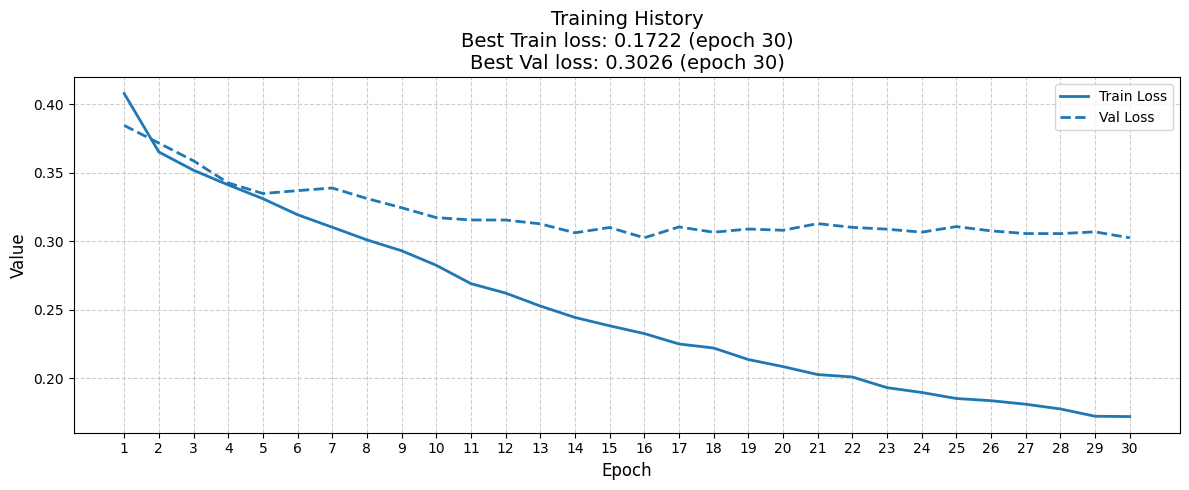

273/273 [==============================] - 1s 1ms/step


In [33]:
selected_lstm_model = hour_models[selected_lstm]
tf.keras.backend.clear_session()  # Reset TensorFlow state
set_random_seed(42) 
lstm_model = selected_lstm_model[0](**selected_lstm_model[1])
lstm_history = lstm_model.fit(
    lstm_X_train,
    lstm_y_train,
    validation_data=(lstm_X_val, lstm_y_val),
    **selected_lstm_model[2],
)
plot_history(lstm_history)
lstm_pred = lstm_model.predict(lstm_X_test)
lstm_pred_df = pd.DataFrame(lstm_pred, index=lstm_y_test.index)

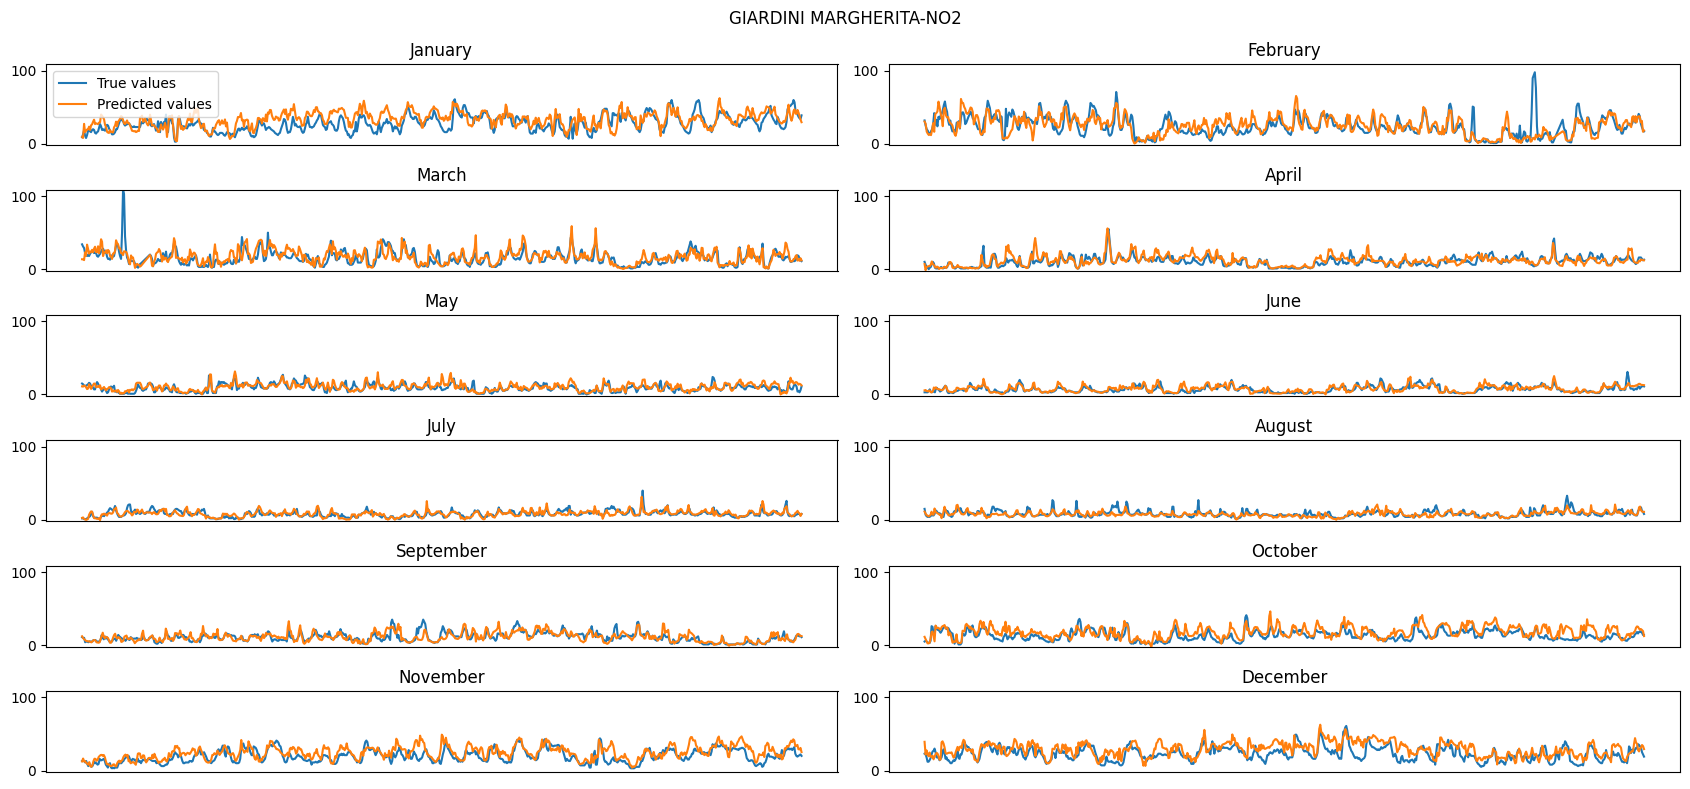

root_mean_squared_error: 0.5945506035519006
r2_score: 0.4985209543108786
mean_absolute_error: 0.40718061742492623
mean_squared_error: 0.3534904201839293


In [35]:
plot_months_predictions(lstm_y_test, lstm_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

#### Feed Forward Neural Network

##### *Models*

In [36]:
ffnn_params = {
    'input_size': n_hour_features,
    'neurons': [1024, 512, 256, 128],
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN'] = (build_ffnn_model, ffnn_params, ffnn_train_params, False)

In [38]:
ffnn2_params = {
    'input_size': n_hour_features,
    'neurons': [512, 256, 128],
    'dropout': 0.3,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn2_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN 2'] = (build_ffnn_model, ffnn2_params, ffnn2_train_params, False)

In [39]:
bn_ffnn2_params = {
    'input_size': n_hour_features,
    'neurons': [512, 256, 128],
    'batch_norm': True,
    'dropout': 0.3,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

bn_ffnn2_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN 2 BatchNorm'] = (build_ffnn_model, bn_ffnn2_params, bn_ffnn2_train_params, False)

##### *Testing*

In [76]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_ffnn = 'Feed Forward NN 2 BatchNorm'

Epoch 1/10
1203/1203 [==============================] - 9s 7ms/step - loss: 0.5121 - val_loss: 0.4605
Epoch 2/10
1203/1203 [==============================] - 8s 7ms/step - loss: 0.4726 - val_loss: 0.4276
Epoch 3/10
1203/1203 [==============================] - 9s 7ms/step - loss: 0.4629 - val_loss: 0.4175
Epoch 4/10
1203/1203 [==============================] - 8s 7ms/step - loss: 0.4577 - val_loss: 0.4437
Epoch 5/10
1203/1203 [==============================] - 8s 7ms/step - loss: 0.4549 - val_loss: 0.4147
Epoch 6/10
1203/1203 [==============================] - 8s 6ms/step - loss: 0.4540 - val_loss: 0.4743
Epoch 7/10
1203/1203 [==============================] - 8s 6ms/step - loss: 0.4527 - val_loss: 0.4339
Epoch 8/10
1203/1203 [==============================] - 8s 7ms/step - loss: 0.4476 - val_loss: 0.4133
Epoch 9/10
1203/1203 [==============================] - 11s 9ms/step - loss: 0.4455 - val_loss: 0.4359
Epoch 10/10
1203/1203 [==============================] - 8s 6ms/step - loss: 0.44

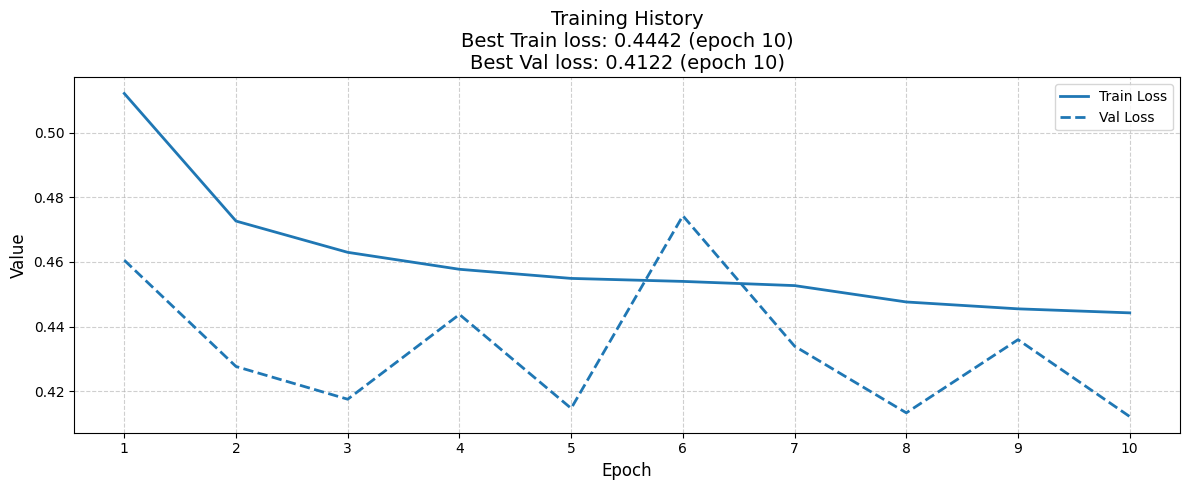

273/273 [==============================] - 1s 3ms/step


In [ ]:
tf.keras.backend.clear_session()  
set_random_seed(42) 

validation_ratio = 0.1
X_train, y_train = train_sets[station][agent]['x'], train_sets[station][agent]['y']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42, shuffle=True)
validation_data = [(X_val, y_val)]

ffnn_model = build_ffnn_model(**hour_models[selected_ffnn][1])
ffnn_history = ffnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    **hour_models[selected_ffnn][2]
)
plot_history(ffnn_history)
ffnn_pred = ffnn_model.predict(test_sets[station][agent]['x'])
ffnn_pred_df = pd.DataFrame(ffnn_pred, index=test_sets[station][agent]['y'].index)

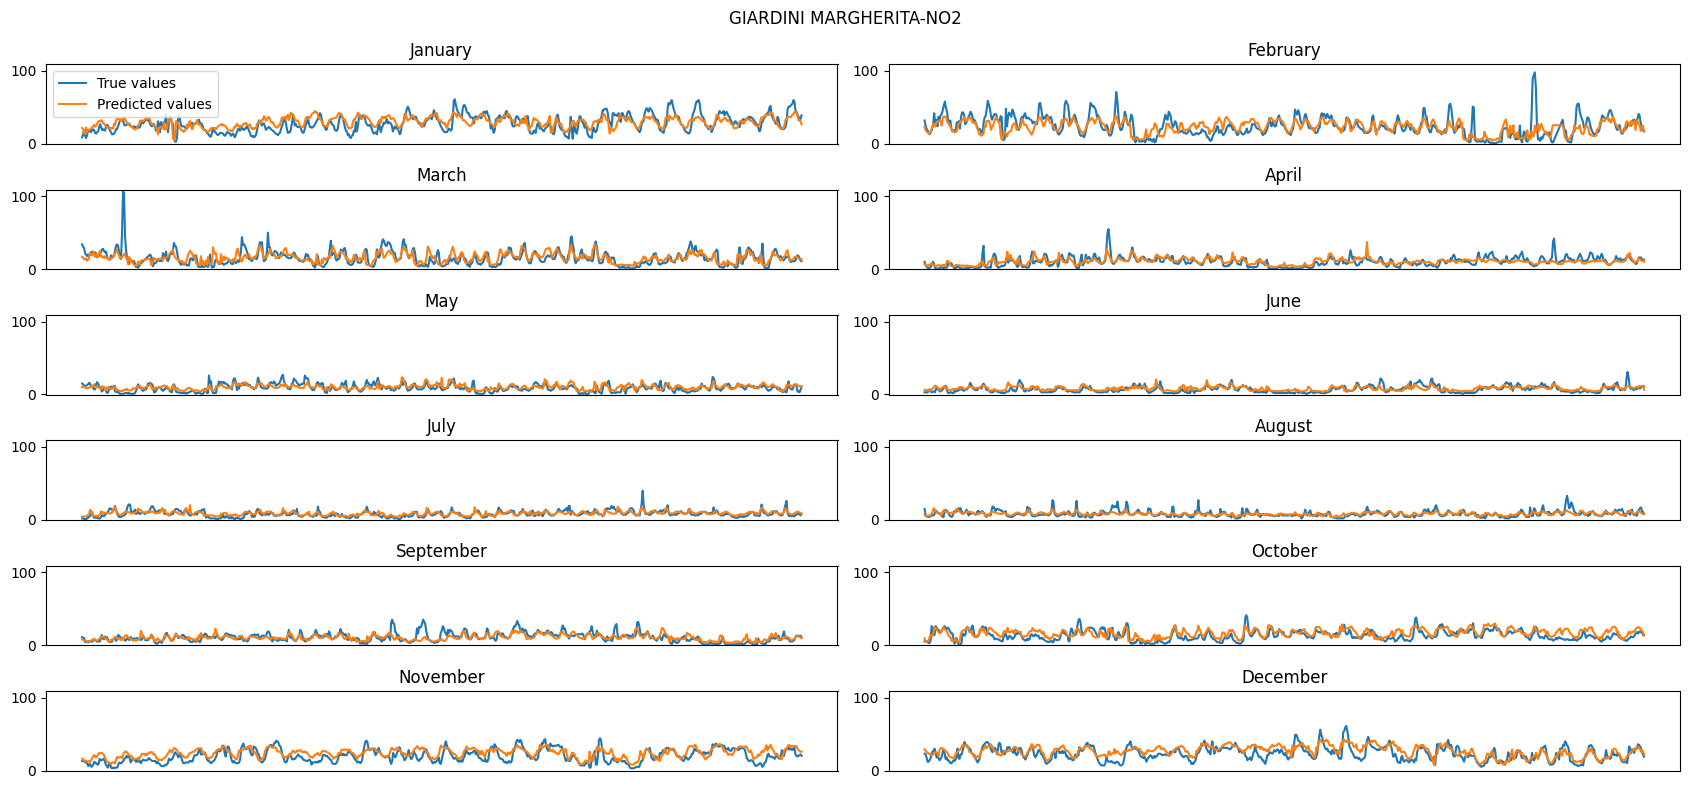

root_mean_squared_error: 0.5352766821221556
r2_score: 0.5935269165880974
mean_absolute_error: 0.37690883593314695
mean_squared_error: 0.2865211264237032


In [80]:
plot_months_predictions(test_sets[station][agent]['y'], ffnn_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

#### Conv1d

##### *Models*

In [43]:
conv_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': 64,
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

hour_models['Conv1D'] = (build_conv_model, conv_params, conv_train_params, True)

In [44]:
conv2_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv2_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

hour_models['Conv1D 2'] = (build_conv_model, conv2_params, conv2_train_params, True)

In [45]:
conv3_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv3_train_params = {
    'epochs': 20,
    'batch_size': 32,
}

hour_models['Conv1D 3'] = (build_conv_model, conv3_params, conv3_train_params, True)

##### *Testing*

In [46]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

selected_conv = 'Conv1D'

In [47]:
validation_ratio = 0.1
selected_conv_model = hour_models[selected_conv]

ts = selected_conv_model[1]['time_steps']
conv_X_train, conv_y_train = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], ts, use_mask=False)

conv_X_test = pd.concat([train_sets[station][agent]['x'].iloc[-ts+1:], test_sets[station][agent]['x']]) # to also compute the first days we need time_steps more days
conv_X_test, conv_y_test = create_sequences(conv_X_test, test_sets[station][agent]['y'], ts, use_mask=False)

conv_X_train, conv_X_val, conv_y_train, conv_y_val = train_test_split(conv_X_train, conv_y_train, test_size=validation_ratio, random_state=42, shuffle=True)

Epoch 1/10
601/601 [==============================] - 2s 3ms/step - loss: 0.4188 - val_loss: 0.3930
Epoch 2/10
601/601 [==============================] - 2s 3ms/step - loss: 0.3810 - val_loss: 0.3835
Epoch 3/10
601/601 [==============================] - 2s 3ms/step - loss: 0.3684 - val_loss: 0.3728
Epoch 4/10
601/601 [==============================] - 2s 3ms/step - loss: 0.3599 - val_loss: 0.3627
Epoch 5/10
601/601 [==============================] - 2s 3ms/step - loss: 0.3526 - val_loss: 0.3631
Epoch 6/10
601/601 [==============================] - 2s 3ms/step - loss: 0.3464 - val_loss: 0.3521
Epoch 7/10
601/601 [==============================] - 2s 3ms/step - loss: 0.3416 - val_loss: 0.3492
Epoch 8/10
601/601 [==============================] - 2s 3ms/step - loss: 0.3363 - val_loss: 0.3539
Epoch 9/10
601/601 [==============================] - 2s 3ms/step - loss: 0.3313 - val_loss: 0.3442
Epoch 10/10
601/601 [==============================] - 2s 3ms/step - loss: 0.3276 - val_loss: 0.3501

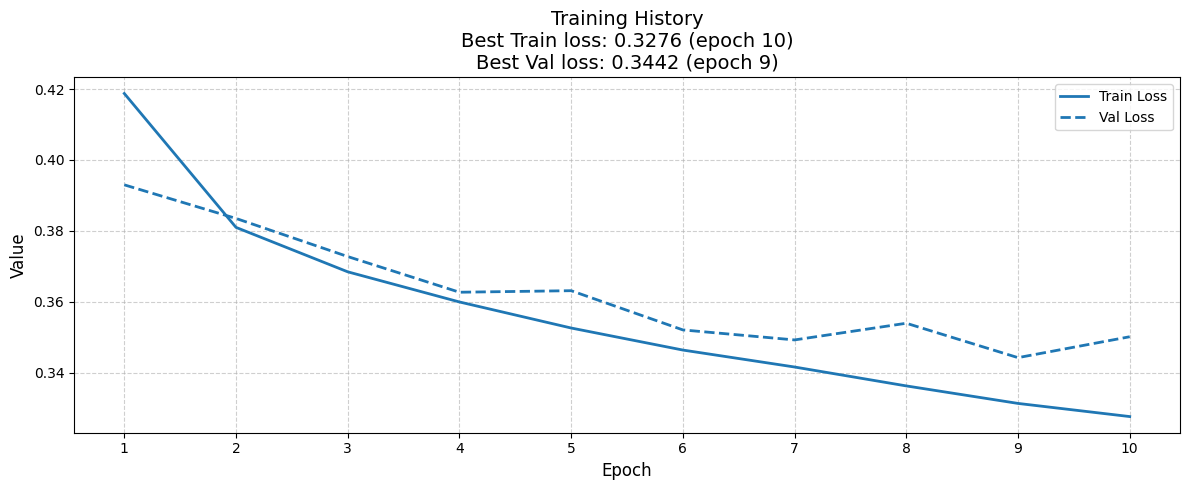

273/273 [==============================] - 0s 831us/step


In [82]:
tf.keras.backend.clear_session()  
set_random_seed(42) 
conv_model = build_conv_model(**hour_models[selected_conv][1])
conv_history = conv_model.fit(
    conv_X_train, 
    conv_y_train, 
    validation_data=(conv_X_val, conv_y_val),
    **hour_models[selected_conv][2])
plot_history(conv_history)
conv_pred = conv_model.predict(conv_X_test)
conv_pred_df = pd.DataFrame(conv_pred, index=conv_y_test.index)

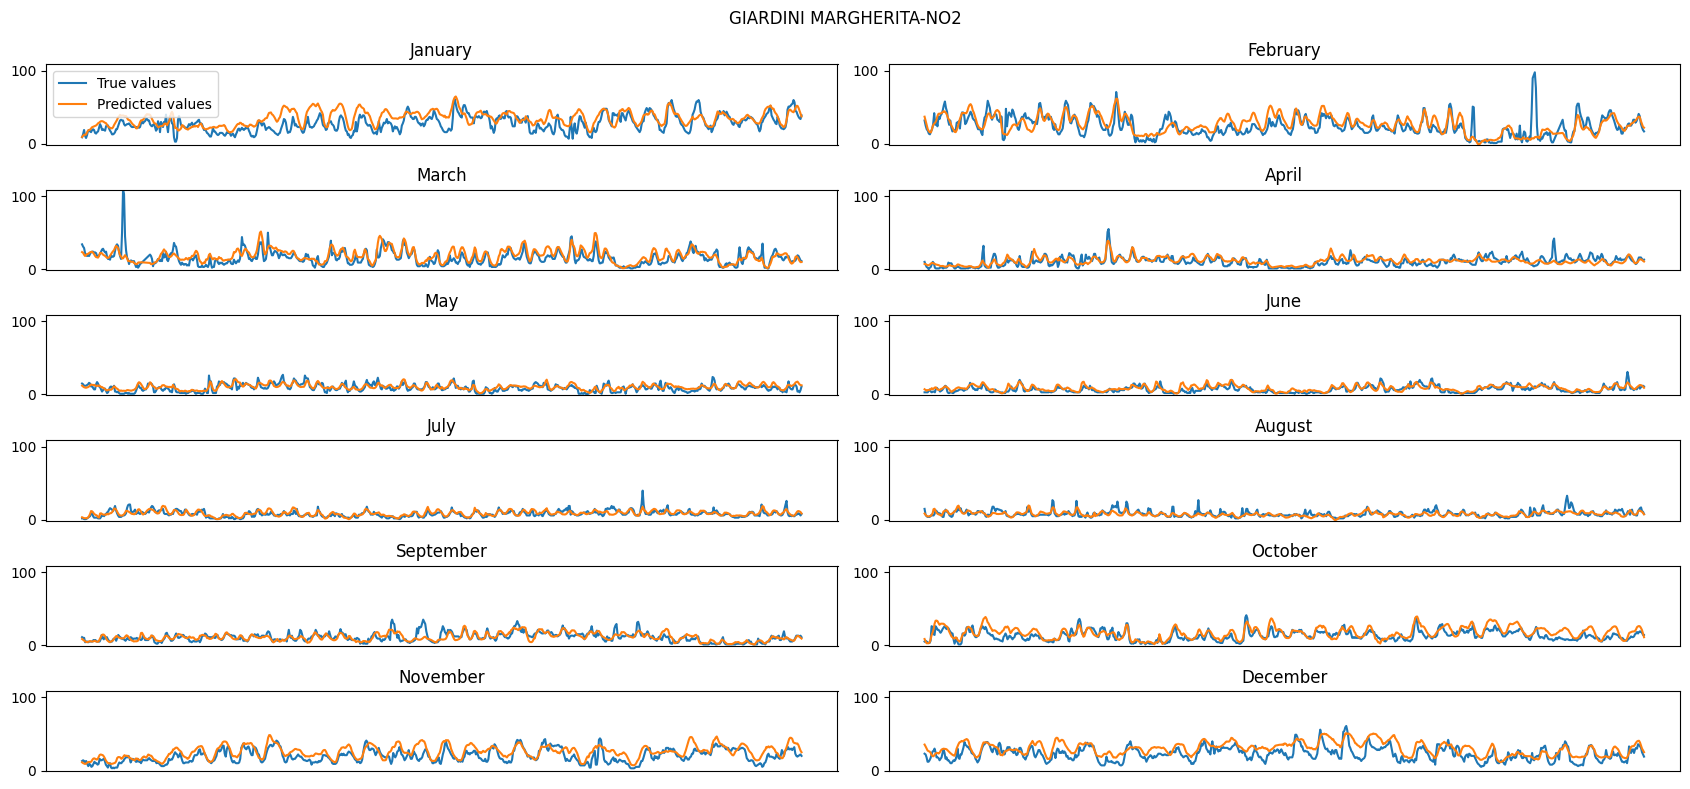

root_mean_squared_error: 0.5719242217418824
r2_score: 0.5359635220200116
mean_absolute_error: 0.39419407078061175
mean_squared_error: 0.3270973154150578


In [83]:
plot_months_predictions(test_sets[station][agent]['y'], conv_pred_df, dist_dict=station_dists[station][agent], metrics=metrics, title=f'{station}-{agent}')

### **Daily Models**

In [50]:
daily_models = {} # contains tuples: (ModelClass, model_params:dict, training_params:dict, uses_sequences:bool|dict)

#### Random Forest Regressor

##### *Models*

In [51]:
rfr_params = {
    'n_estimators':100,
    'max_depth':10,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

daily_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

In [52]:
rfr2_params = {
    'n_estimators':150,
    'max_depth':20,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

daily_models['Random Forest Regressor 2'] = (RandomForestRegressor, rfr2_params, None, False)

##### *Testing*

In [53]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_rfr = 'Random Forest Regressor'

In [54]:
rfr_daily_model = RandomForestRegressor(**daily_models[selected_daily_rfr][1])
rfr_daily_model.fit(train_sets[station][agent]['x'], train_sets[station][agent]['y'].to_numpy().ravel())
rfr_daily_pred = rfr_daily_model.predict(test_sets[station][agent]['x'])
rfr_daily_pred_df = pd.DataFrame(rfr_daily_pred, index=test_sets[station][agent]['y'].index)

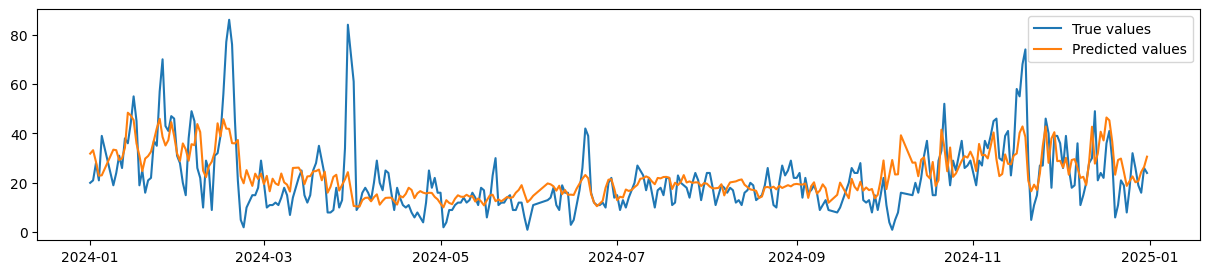

root_mean_squared_error: 0.7226040670311698
r2_score: 0.42151823804631827
mean_absolute_error: 0.5118303482958196
mean_squared_error: 0.5221566376899873


In [55]:
plot_year_predictions(test_sets[station][agent]['y'], rfr_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### XGBoost Regressor

##### *Models*

In [56]:
xgbr_params = {
    'objective': "reg:squarederror",
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9,
    'random_state': RANDOM_STATE,
}

daily_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

In [57]:
xgbr_params = {
    'objective': "reg:squarederror",
    'n_estimators': 150,
    'max_depth': 10,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'random_state': RANDOM_STATE,
}

daily_models['XGB Regressor 2'] = (xgb.XGBRegressor, xgbr_params, None, False)

##### *Testing*

In [58]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_xgbr = 'XGB Regressor'

In [59]:
validation_ratio = 0.1

X_train, y_train = train_sets[station][agent]['x'], train_sets[station][agent]['y']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42, shuffle=True)
validation_data = [(X_val, y_val)]

xgbr_daily_model = xgb.XGBRegressor(**hour_models[selected_daily_xgbr][1])
xgbr_daily_model.fit(X_train, y_train, eval_set=validation_data)
xgbr_daily_pred = xgbr_daily_model.predict(test_sets[station][agent]['x'])
xgbr_daily_pred_df = pd.DataFrame(xgbr_daily_pred, index=test_sets[station][agent]['y'].index)

[0]	validation_0-mae:0.67558
[1]	validation_0-mae:0.65983
[2]	validation_0-mae:0.64428
[3]	validation_0-mae:0.63250
[4]	validation_0-mae:0.62069
[5]	validation_0-mae:0.61079
[6]	validation_0-mae:0.60011
[7]	validation_0-mae:0.59285
[8]	validation_0-mae:0.58320
[9]	validation_0-mae:0.57797
[10]	validation_0-mae:0.57278
[11]	validation_0-mae:0.56772
[12]	validation_0-mae:0.56271
[13]	validation_0-mae:0.55575
[14]	validation_0-mae:0.55454
[15]	validation_0-mae:0.55027
[16]	validation_0-mae:0.54688
[17]	validation_0-mae:0.54635
[18]	validation_0-mae:0.54141
[19]	validation_0-mae:0.53597
[20]	validation_0-mae:0.53420
[21]	validation_0-mae:0.53152
[22]	validation_0-mae:0.53147
[23]	validation_0-mae:0.52806
[24]	validation_0-mae:0.52657
[25]	validation_0-mae:0.52311
[26]	validation_0-mae:0.52052
[27]	validation_0-mae:0.51992
[28]	validation_0-mae:0.51831
[29]	validation_0-mae:0.51518
[30]	validation_0-mae:0.51406
[31]	validation_0-mae:0.51189
[32]	validation_0-mae:0.51138
[33]	validation_0-ma

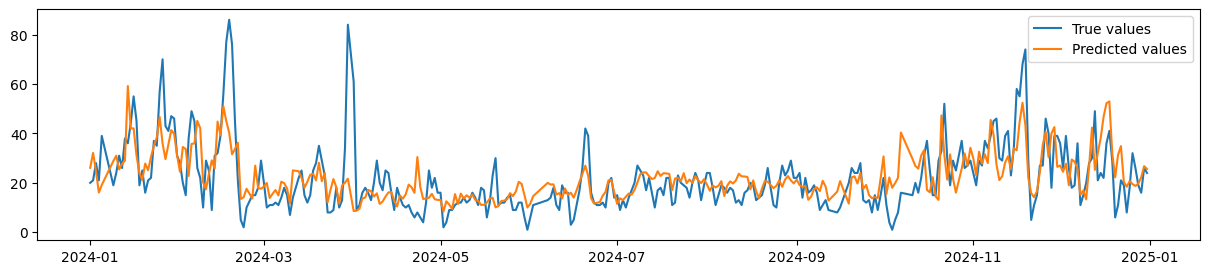

root_mean_squared_error: 0.7332324302153088
r2_score: 0.4043759867518588
mean_absolute_error: 0.5121508254523127
mean_squared_error: 0.5376297967194478


In [60]:
plot_year_predictions(test_sets[station][agent]['y'], xgbr_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### Feed Forward Neural Network

##### *Models*

In [61]:
ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

daily_models['Feed Forward NN'] = (build_ffnn_model, ffnn_daily_params, ffnn_daily_train_params, False)

In [62]:
bn_ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'batch_norm': True,
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

bn_ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

daily_models['Feed Forward NN BatchNorm'] = (build_ffnn_model, bn_ffnn_daily_params, bn_ffnn_daily_train_params, False)

##### *Testing*

In [63]:
station = 'GIARDINI MARGHERITA'
agent = 'PM10'

selected_daily_ffnn = 'Feed Forward NN'

In [64]:
tf.keras.backend.clear_session()  
set_random_seed(42) 
ffnn_daily_model = build_ffnn_model(**daily_models[selected_daily_ffnn][1])
ffnn_daily_model.fit(
    train_sets[station][agent]['x'], 
    train_sets[station][agent]['y'], 
    **daily_models[selected_daily_ffnn][2]
    )
ffnn_daily_pred = ffnn_daily_model.predict(test_sets[station][agent]['x'])
ffnn_daily_pred_df = pd.DataFrame(ffnn_daily_pred, index=test_sets[station][agent]['y'].index)

Epoch 1/20
55/55 [==============================] - 1s 5ms/step - loss: 0.6245
Epoch 2/20
55/55 [==============================] - 0s 5ms/step - loss: 0.5368
Epoch 3/20
55/55 [==============================] - 0s 5ms/step - loss: 0.5267
Epoch 4/20
55/55 [==============================] - 0s 5ms/step - loss: 0.5143
Epoch 5/20
55/55 [==============================] - 0s 5ms/step - loss: 0.5063
Epoch 6/20
55/55 [==============================] - 0s 5ms/step - loss: 0.4966
Epoch 7/20
55/55 [==============================] - 0s 6ms/step - loss: 0.4755
Epoch 8/20
55/55 [==============================] - 0s 5ms/step - loss: 0.4721
Epoch 9/20
55/55 [==============================] - 0s 5ms/step - loss: 0.4611
Epoch 10/20
55/55 [==============================] - 0s 5ms/step - loss: 0.4558
Epoch 11/20
55/55 [==============================] - 0s 5ms/step - loss: 0.4454
Epoch 12/20
55/55 [==============================] - 0s 5ms/step - loss: 0.4402
Epoch 13/20
55/55 [==============================

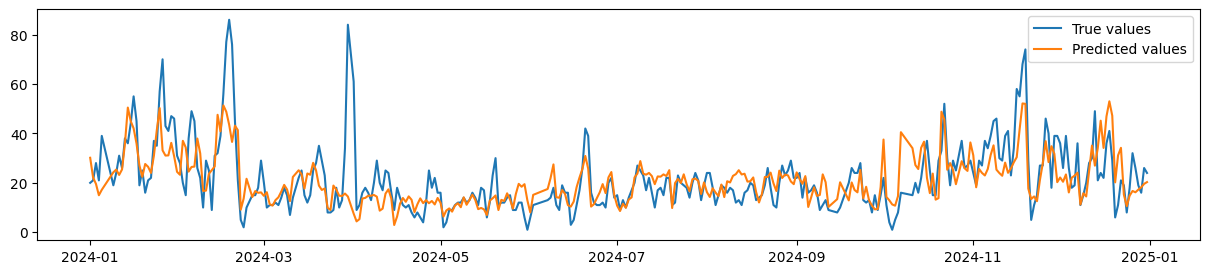

root_mean_squared_error: 0.718767831546796
r2_score: 0.4276441419102015
mean_absolute_error: 0.49124156886091574
mean_squared_error: 0.5166271956664833


In [65]:
plot_year_predictions(test_sets[station][agent]['y'], ffnn_daily_pred_df, dist_dict=station_dists[station][agent], metrics=metrics)

#### LSTM

In order to use LSTMs, we need to have sequences/time steps. For the other models, we aggregated the hourly data into a single day, but we could try to go back to hourly inputs aggregated in sequences of 24 hours.

The tests results were not convincing enough to keep experimentating.

## **Agents Evaluations**

### Hourly Models

In [70]:
hour_results = train_models(
    hour_models,train_sets,test_sets,metrics,
    to_execute={
        'agents':'all',
        'stations':'all',
        'models':'all',
    },
    ignore={
        'stations':[],
        'agents':['PM10','PM2.5'],
        'models':[]
        },
    random_state=RANDOM_STATE,
    v=1
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['C6H6', 'CO', 'O3', 'NO2']
models: ['Random Forest Regressor', 'Random Forest Regressor 2', 'XGB Regressor', 'XGB Regressor 2', 'LSTM', 'LSTM-masked', 'LSTM 2', 'LSTM 2-masked', 'Feed Forward NN', 'Feed Forward NN 2', 'Feed Forward NN 2 BatchNorm', 'Conv1D', 'Conv1D 2', 'Conv1D 3']
Agent C6H6
> Random Forest Regressor model:
 >> Training station PORTA SAN FELICE...
> Random Forest Regressor 2 model:
 >> Training station PORTA SAN FELICE...
> XGB Regressor model:
 >> Training station PORTA SAN FELICE...
> XGB Regressor 2 model:
 >> Training station PORTA SAN FELICE...
> LSTM model:
 >> Training station PORTA SAN FELICE...
> LSTM-masked model:
 >> Training station PORTA SAN FELICE...
> LSTM 2 model:
 >> Training station PORTA SAN FELICE...
> LSTM 2-masked model:
 >> Training station PORTA SAN FELICE...
> Feed Forward NN model:
 >> Training station PORTA SAN FELICE...
> Feed Forward NN 2 model:


We can extract the results from the training phase, and sort the models using their metrics.

In [71]:
hour_extracted_data = training_results_to_dataframe(hour_results)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(hour_extracted_data.sort_values(by=['Station','Agent','root_mean_squared_error']))

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,mean_squared_error
26,GIARDINI MARGHERITA,NO2,Conv1D 2,0.525926,0.607604,0.358271,0.276598
25,GIARDINI MARGHERITA,NO2,Conv1D,0.532855,0.597196,0.360495,0.283935
27,GIARDINI MARGHERITA,NO2,Conv1D 3,0.543922,0.580291,0.374283,0.295851
21,GIARDINI MARGHERITA,NO2,LSTM 2-masked,0.572564,0.534925,0.384873,0.327829
18,GIARDINI MARGHERITA,NO2,LSTM,0.578323,0.525522,0.394882,0.334457
16,GIARDINI MARGHERITA,NO2,XGB Regressor,0.583350,0.517238,0.412623,0.340297
24,GIARDINI MARGHERITA,NO2,Feed Forward NN 2 BatchNorm,0.585573,0.513551,0.416875,0.342896
20,GIARDINI MARGHERITA,NO2,LSTM 2,0.586190,0.512526,0.396136,0.343618
15,GIARDINI MARGHERITA,NO2,Random Forest Regressor 2,0.591327,0.503944,0.439246,0.349668
14,GIARDINI MARGHERITA,NO2,Random Forest Regressor,0.591357,0.503894,0.438979,0.349703


And we can display the best model for each station-agent

In [72]:
display(hour_extracted_data.loc[hour_extracted_data.groupby(by=['Station','Agent'])['root_mean_squared_error'].idxmin()])

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,mean_squared_error
26,GIARDINI MARGHERITA,NO2,Conv1D 2,0.525926,0.607604,0.358271,0.276598
13,GIARDINI MARGHERITA,O3,Conv1D 3,0.355730,0.857860,0.267032,0.126544
40,PORTA SAN FELICE,C6H6,Conv1D 2,0.559259,0.660462,0.350356,0.312771
44,PORTA SAN FELICE,CO,XGB Regressor,0.664817,0.577301,0.511027,0.441982
65,PORTA SAN FELICE,NO2,Feed Forward NN 2,0.881743,-0.439108,0.749211,0.777470
86,VIA CHIARINI,NO2,XGB Regressor,0.514019,0.571648,0.389214,0.264215
81,VIA CHIARINI,O3,Conv1D,0.332717,0.872502,0.250762,0.110701


Apparently, there isn't a particular model that performs well on an agent across all the stations. That being said, the loss values are really similar and with a better fine tuning a certain model might become the best for certain agents.

Even if this results descourage it, trying to define per-agent models, instead of the current station-agent models, might be worth it. We could obtain more general models. In that case, the train set would also become larger because the data from all the stations would be used.

### Daily Models

In [73]:
daily_results = train_models(
    daily_models, train_sets, test_sets, metrics,
    to_execute={
        'agents':['PM10','PM2.5'],
        'stations':'all',
        'models':'all',
        },
    ignore={
        'stations':[],
        'agents':[],
        'models':[]
        },
    v=1
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['PM10', 'PM2.5']
models: ['Random Forest Regressor', 'Random Forest Regressor 2', 'XGB Regressor', 'XGB Regressor 2', 'Feed Forward NN', 'Feed Forward NN BatchNorm']
Agent PM10
> Random Forest Regressor model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> Random Forest Regressor 2 model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> XGB Regressor model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> XGB Regressor 2 model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> Feed Forward NN model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training s

In [74]:
daily_extracted_data = training_results_to_dataframe(daily_results)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(daily_extracted_data.sort_values(by=['Station','Agent','root_mean_squared_error']))

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,mean_squared_error
5,GIARDINI MARGHERITA,PM10,Feed Forward NN BatchNorm,0.714385,0.434603,0.502577,0.510346
0,GIARDINI MARGHERITA,PM10,Random Forest Regressor,0.722604,0.421518,0.511830,0.522157
4,GIARDINI MARGHERITA,PM10,Feed Forward NN,0.724131,0.419070,0.486492,0.524366
1,GIARDINI MARGHERITA,PM10,Random Forest Regressor 2,0.731112,0.407816,0.515383,0.534525
3,GIARDINI MARGHERITA,PM10,XGB Regressor 2,0.753299,0.371328,0.540747,0.567460
2,GIARDINI MARGHERITA,PM10,XGB Regressor,0.767335,0.347683,0.551656,0.588803
10,GIARDINI MARGHERITA,PM2.5,Feed Forward NN,0.704822,0.506765,0.491546,0.496775
6,GIARDINI MARGHERITA,PM2.5,Random Forest Regressor,0.732106,0.467839,0.509055,0.535979
7,GIARDINI MARGHERITA,PM2.5,Random Forest Regressor 2,0.732163,0.467757,0.512147,0.536062
11,GIARDINI MARGHERITA,PM2.5,Feed Forward NN BatchNorm,0.743472,0.451187,0.517296,0.552751


In [75]:
display(daily_extracted_data.loc[daily_extracted_data.groupby(by=['Station','Agent'])['root_mean_squared_error'].idxmin()])

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,mean_squared_error
5,GIARDINI MARGHERITA,PM10,Feed Forward NN BatchNorm,0.714385,0.434603,0.502577,0.510346
10,GIARDINI MARGHERITA,PM2.5,Feed Forward NN,0.704822,0.506765,0.491546,0.496775
16,PORTA SAN FELICE,PM10,Feed Forward NN,0.702841,0.511023,0.464813,0.493985
22,PORTA SAN FELICE,PM2.5,Feed Forward NN,0.642601,0.599170,0.450156,0.412936
24,VIA CHIARINI,PM10,Random Forest Regressor,0.845451,0.306857,0.646139,0.714787


Feed Forwards models seem to perform better than the others. In particular, the same architecture with or without batchnorm is successful. 